In [1]:
import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from omegaconf import OmegaConf
from hovsg.graph.graph import Graph
from hydra import initialize, compose
import open3d as o3d
import torch
import networkx as nx
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

import open_clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from hovsg.utils.constants import MATTERPORT_GT_LABELS, CLIP_DIM

from hovsg.dataloader.hm3dsem import HM3DSemDataset
from hovsg.dataloader.scannet import ScannetDataset
from hovsg.dataloader.replica import ReplicaDataset
from hovsg.dataloader.truckscenes import TruckScenesDataset
import matplotlib.pyplot as plt
from hovsg.models.sam_clip_feats_extractor import extract_feats_per_pixel

from hovsg.utils.graph_utils import (
    seq_merge,
    pcd_denoise_dbscan,
    feats_denoise_dbscan,
    distance_transform,
    map_grid_to_point_cloud,
    compute_room_embeddings,
    find_intersection_share,
    hierarchical_merge,
)


from hovsg.utils.metric import (
    frequency_weighted_iou,
    mean_iou,
    mean_accuracy,
    pixel_accuracy,
    per_class_iou,
)

from hovsg.labels.label_constants import (
    TRUCKSCENES_LABELS,
    TRUCKSCENES_COLORMAP
)

IGNORE_CLASS_INDEX = 12
TRUCKSCENES_LABELS_TO_IDX = {
    "animal": 0,
    "human.pedestrian.adult": 7,
    "human.pedestrian.child": 7,
    "human.pedestrian.construction_worker": 7,
    "human.pedestrian.personal_mobility": 7,
    "human.pedestrian.police_officer": 7,
    "human.pedestrian.stroller": IGNORE_CLASS_INDEX,
    "human.pedestrian.wheelchair": IGNORE_CLASS_INDEX,
    "movable_object.barrier": 1,
    "movable_object.debris": IGNORE_CLASS_INDEX,
    "movable_object.pushable_pullable": IGNORE_CLASS_INDEX,
    "movable_object.trafficcone": 8,
    "static_object.bicycle_rack": IGNORE_CLASS_INDEX,
    "static_object.traffic_sign": 9,
    "vehicle.bicycle": 2,
    "vehicle.bus.bendy": 3,
    "vehicle.bus.rigid": 3,
    "vehicle.car": 4,
    "vehicle.construction": 6,
    "vehicle.emergency.ambulance": IGNORE_CLASS_INDEX,
    "vehicle.emergency.police": IGNORE_CLASS_INDEX,
    "vehicle.motorcycle": 5,
    "vehicle.trailer": 10,
    "vehicle.truck": 11,
    "vehicle.train": IGNORE_CLASS_INDEX,
    "vehicle.other": IGNORE_CLASS_INDEX,
    "vehicle.ego_trailer": IGNORE_CLASS_INDEX,
    "unlabeled": IGNORE_CLASS_INDEX
}

TRUCKSCENES_LABELS = (
    'animal', 
    'barrier', 
    'bicycle', 
    'bus', 
    'car', 
    'motorcycle', 
    'construction vehicle', 
    'person', 
    'traffic cone',
    'traffic sign', 
    'trailer', 
    'truck', 
    'other'
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [3]:

# Manually initialize Hydra and load the config
config_path = "../config"
config_name = "semantic_segmentation"

# Hydra context for manual loading
with initialize(version_base=None, config_path=config_path):
    params = compose(config_name=config_name)

# Create save directory
save_dir = os.path.join(params.main.save_path, params.main.dataset)
os.makedirs(save_dir, exist_ok=True)

In [4]:
scene_name = "scene-0c2e941c5ba2476b9e20b29ce4c678b9-3"
scene_name = "scene-40b113e5ad554aa089f7f6f5dc2c4c3f-3"

In [5]:
cfg = params
full_pcd = o3d.geometry.PointCloud()
mask_feats = []
mask_feats_d = []
mask_pcds = []
mask_weights = []
objects = []
rooms = []
floors = []
full_feats_array = []
graph = nx.Graph()
graph.add_node(0, name="building", type="building")
room_masks = {}
device = "cuda" if torch.cuda.is_available() else "cpu"

# load CLIP model
if cfg.models.clip.type == "ViT-L/14@336px":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-L-14",
        pretrained=str(cfg.models.clip.checkpoint),
        device=device,
    )
    clip_feat_dim = CLIP_DIM["ViT-L-14"]
    # clip_feat_dim = constants.clip_feat_dim[cfg.models.clip.type]
elif cfg.models.clip.type == "ViT-H-14":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14",
        pretrained=str(cfg.models.clip.checkpoint),
        device=device,
    )
    clip_feat_dim = CLIP_DIM["ViT-H-14"]
clip_model.eval()

# load the SAM model
model_type = cfg.models.sam.type
sam = sam_model_registry[model_type](
    checkpoint=str(cfg.models.sam.checkpoint)
)
sam.to(device=device)


# load the dataset
dataset_cfg = {"root_dir": cfg.main.dataset_path, "transforms": None}
dataset = TruckScenesDataset(dataset_cfg, scene=scene_name)


In [6]:
if dataset is None:
    print("No dataset loaded")

# create the RGB-D point cloud
for i in tqdm(range(0, len(dataset), cfg.pipeline.skip_frames), desc="Creating RGB-D point cloud"):
    rgb_image, depth_image, pose, _, depth_intrinsics = dataset[i]
    new_pcd = dataset.create_pcd(rgb_image, depth_image, pose)
    full_pcd += new_pcd

# filter point cloud
print("Size before filtering:", len(full_pcd.points))
full_pcd = full_pcd.voxel_down_sample(
    voxel_size=cfg.pipeline.voxel_size
)
# full_pcd = pcd_denoise_dbscan(full_pcd, eps=0.01, min_points=100)
print("Size after filtering:", len(full_pcd.points))
# create tree from full point cloud
locs_in = np.array(full_pcd.points)
tree_pcd = cKDTree(locs_in)
n_points = locs_in.shape[0]
counter = torch.zeros((n_points, 1), device="cpu")
sum_features = torch.zeros((n_points, clip_feat_dim), device="cpu")


Creating RGB-D point cloud: 100%|██████████| 160/160 [00:03<00:00, 44.85it/s]


Size before filtering: 302169
Size after filtering: 227404


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from hovsg.utils.clip_utils import get_img_feats, get_img_feats_batch
from hovsg.utils.sam_utils import crop_all_bounding_boxs, filter_masks

def filter_masks(masks, overlap_threshold):
    # 1) compute each mask’s area
    for mask in masks:
        seg = mask["segmentation"]
        mask["area"] = seg.sum()

    # 2) sort descending
    masks_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)

    # 3) filter by >80% overlap
    overlap_threshold = 0.8
    kept_masks = []

    for m in masks_sorted:
        seg = m["segmentation"]
        area_m = m["area"]
        drop = False

        for km in kept_masks:
            # compute intersection
            inter = np.logical_and(seg, km["segmentation"]).sum()
            # if intersection covers >80% of the *current* (smaller) mask, drop it
            if inter / area_m > overlap_threshold:
                drop = True
                break

        if not drop:
            kept_masks.append(m)
            
    return kept_masks

def extract_feats_per_pixel(
    image,
    mask_generator,
    clip_model,
    preprocess,
    clip_feat_dim=768,
    bbox_margin=0,
    maskedd_weight=0.75,
):
    """
    Estimate the feature for each pixel in the image using ConceptFusion method.
    """
    LOAD_IMG_HEIGHT, LOAD_IMG_WIDTH = image.shape[0], image.shape[1]
    masks = mask_generator.generate(image)

    # # ------------------------------------------------------------------------
    # --- Step 1: compute area for each mask and attach it ---
    # OVERLAP_THRESH = 0.8
    # masks = filter_masks(masks, OVERLAP_THRESH)
    # # 1) compute each mask’s area
    # for mask in masks:
    #     seg = mask["segmentation"]
    #     mask["area"] = seg.sum()

    # # 2) sort descending
    # masks_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)

    # # 3) filter by >80% overlap
    # OVERLAP_THRESH = 0.8
    # kept_masks = []

    # for m in masks_sorted:
    #     seg = m["segmentation"]
    #     area_m = m["area"]
    #     drop = False

    #     for km in kept_masks:
    #         # compute intersection
    #         inter = np.logical_and(seg, km["segmentation"]).sum()
    #         # if intersection covers >80% of the *current* (smaller) mask, drop it
    #         if inter / area_m > OVERLAP_THRESH:
    #             drop = True
    #             break

    #     if not drop:
    #         kept_masks.append(m)

    # masks = kept_masks


    F_g = None
    cropped_masked_feats = None
    cropped_feats = None
    if F_g is None and cropped_masked_feats is None and cropped_feats is None:
        F_g = get_img_feats(image, preprocess, clip_model)
        croped_images = crop_all_bounding_boxs(image, masks, block_background=False, bbox_margin=bbox_margin)
        croped_images_masked = crop_all_bounding_boxs(image, masks, block_background=True, bbox_margin=bbox_margin)
        number_of_masks = len(croped_images)

        # for croped_image in croped_images:
        #     plt.imshow(croped_image)
        #     plt.axis("off")
        #     plt.show()

        cropped_masked_feats = get_img_feats_batch(croped_images_masked, preprocess, clip_model)
        cropped_feats = get_img_feats_batch(croped_images, preprocess, clip_model)

    fused_crop_feats = torch.from_numpy(
        maskedd_weight * cropped_masked_feats + (1 - maskedd_weight) * cropped_feats
    )
    F_l = torch.nn.functional.normalize(fused_crop_feats, p=2, dim=-1).cpu().numpy()
    if F_l.shape[0] == 0:
        return None, None, None

    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    phi_l_G = cos(torch.from_numpy(F_l), torch.from_numpy(F_g))
    w_i = torch.nn.functional.softmax(phi_l_G, dim=0).reshape(-1, 1)
    F_p = w_i * F_g + (1 - w_i) * F_l.reshape(number_of_masks, clip_feat_dim)
    F_p = torch.nn.functional.normalize(F_p, p=2, dim=-1)

    F_p = F_p.cuda()
    outfeat = torch.zeros(LOAD_IMG_HEIGHT * LOAD_IMG_WIDTH, clip_feat_dim, device="cuda")
    non_zero_ids = torch.from_numpy(np.array([mask["segmentation"] for mask in masks])).reshape((len(masks), -1))
    for i, mask in enumerate(masks):
        non_zero_indices = torch.argwhere(non_zero_ids[i] == 1).cuda()
        outfeat[non_zero_indices, :] += F_p[i, :]
    outfeat = torch.nn.functional.normalize(outfeat, p=2, dim=-1)
    outfeat = outfeat.half()
    outfeat = outfeat.reshape((LOAD_IMG_HEIGHT, LOAD_IMG_WIDTH, clip_feat_dim))
    return outfeat.cpu(), F_p.cpu(), masks, F_g


In [8]:
import cv2

def create_pcd(dataset, rgb, depth, camera_pose=None, mask_img=False, filter_distance=np.inf):
    """
    Create Open3D point cloud from RGB and depth images, and camera pose. filter_distance is used to filter out
    points that are further than a certain distance.
    :param rgb (pil image): RGB image
    :param depth (pil image): Depth image
    :param camera_pose (np.array): Camera pose
    :param mask_img (bool): Mask image
    :param filter_distance (float): Filter distance
    :return: Open3D point cloud
    """
    # convert rgb and depth images to numpy arrays
    rgb = np.array(rgb).astype(np.uint8)
    depth = np.array(depth)
    # resize rgb image to match depth image size if needed
    if rgb.shape[0] != depth.shape[0] or rgb.shape[1] != depth.shape[1]:
        rgb = cv2.resize(rgb, (depth.shape[1], depth.shape[0]), interpolation=cv2.INTER_AREA)
    # load depth camera intrinsics
    H = rgb.shape[0]
    W = rgb.shape[1]
    camera_matrix = dataset.depth_intrinsics
    scale = dataset.scale
    # create point cloud
    y, x = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    depth = depth.astype(np.float32) / scale
    if mask_img:
        depth = depth * rgb
    mask = depth > 0
    x = x[mask]
    y = y[mask]
    depth = depth[mask]
    # convert to 3D
    X = (x - camera_matrix[0, 2]) * depth / camera_matrix[0, 0]
    Y = (y - camera_matrix[1, 2]) * depth / camera_matrix[1, 1]
    Z = depth
    if Z.mean() > filter_distance:
        return o3d.geometry.PointCloud()
    # convert to open3d point cloud
    points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    if not mask_img:
        colors = rgb[mask]
        pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)
    pcd.transform(camera_pose)
    
    masked_depth = (x, y, depth)
    return pcd, masked_depth

    
def create_3d_masks(dataset, masks, F_masks, depth, full_pcd, full_pcd_tree, camera_pose, down_size=0.02, filter_distance=None):
    """
    create 3d masks from 2D masks
    Args:
        masks: list of 2D masks
        depth: depth image
        full_pcd: full point cloud
        full_pcd_tree: KD-Tree of full point cloud
        camera_pose: camera pose
        down_size: voxel size for downsampling
    Returns:
        list of 3D masks as Open3D point clouds
    """
    pcd_list = []
    feat_list = []
    depth_list = []
    
    pcd = np.asarray(full_pcd.points)
    depth = np.array(depth)
    for i in range(len(masks)):
        # get the mask
        mask = masks[i]["segmentation"]
        mask = np.array(mask)
        # plt.imshow(mask, cmap='gray')
        # plt.imshow(depth, cmap='gray', alpha=0.5)
        # create pcd from mask
        pcd_masked, depth_masked = create_pcd(dataset, mask, depth, camera_pose, mask_img=True, filter_distance=filter_distance)

        
        pcd_masked = np.asarray(pcd_masked.points)
        dist, indices = full_pcd_tree.query(pcd_masked, k=1, workers=-1)
        pcd_masked = pcd[indices]
        pcd_mask = o3d.geometry.PointCloud()
        pcd_mask.points = o3d.utility.Vector3dVector(pcd_masked)
        # colors = np.asarray(full_pcd.colors)
        # colors = colors[indices]
        # pcd_mask.colors = o3d.utility.Vector3dVector(colors)
        # pcd_mask = pcd_mask.voxel_down_sample(voxel_size=down_size)
        
        if np.array(pcd_mask.points).shape[0] == 0:
            continue

        # using KD-Tree to find the nearest points in the point cloud
        # plt.figure(figsize=(10, 10))
        # plt.scatter(pcd[:, 0], pcd[:, 1], s=1, c='b', alpha=0.5)
        # plt.scatter(pcd_masked[:, 0], pcd_masked[:, 1], s=2, c='r', alpha=0.5)
        # plt.title(f"Masked Point Cloud {i}")
        # # plt.gca().set_aspect('equal')
        # plt.show()
        
        pcd_list.append(pcd_mask)
        feat_list.append(F_masks[i])
        depth_list.append(depth_masked)
        
    return pcd_list, feat_list, depth_list

In [9]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    points_per_batch=144,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    min_mask_region_area=50,
    crop_n_layers= 0,  # or 2 if needed
    # crop_n_points_downscale_factor= 4  # reduces resolution in crops
)
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [10]:
scene_path = os.path.join(params.main.dataset_path, "trainval", scene_name, "labelled_points" )
labelled_frame_names = sorted(os.listdir(scene_path), key=lambda x: int(x.split('.')[0]))


# read semantic classes
TRUCKSCENES_LABELS_list = list(TRUCKSCENES_LABELS)
labels_id = list(TRUCKSCENES_COLORMAP.keys())

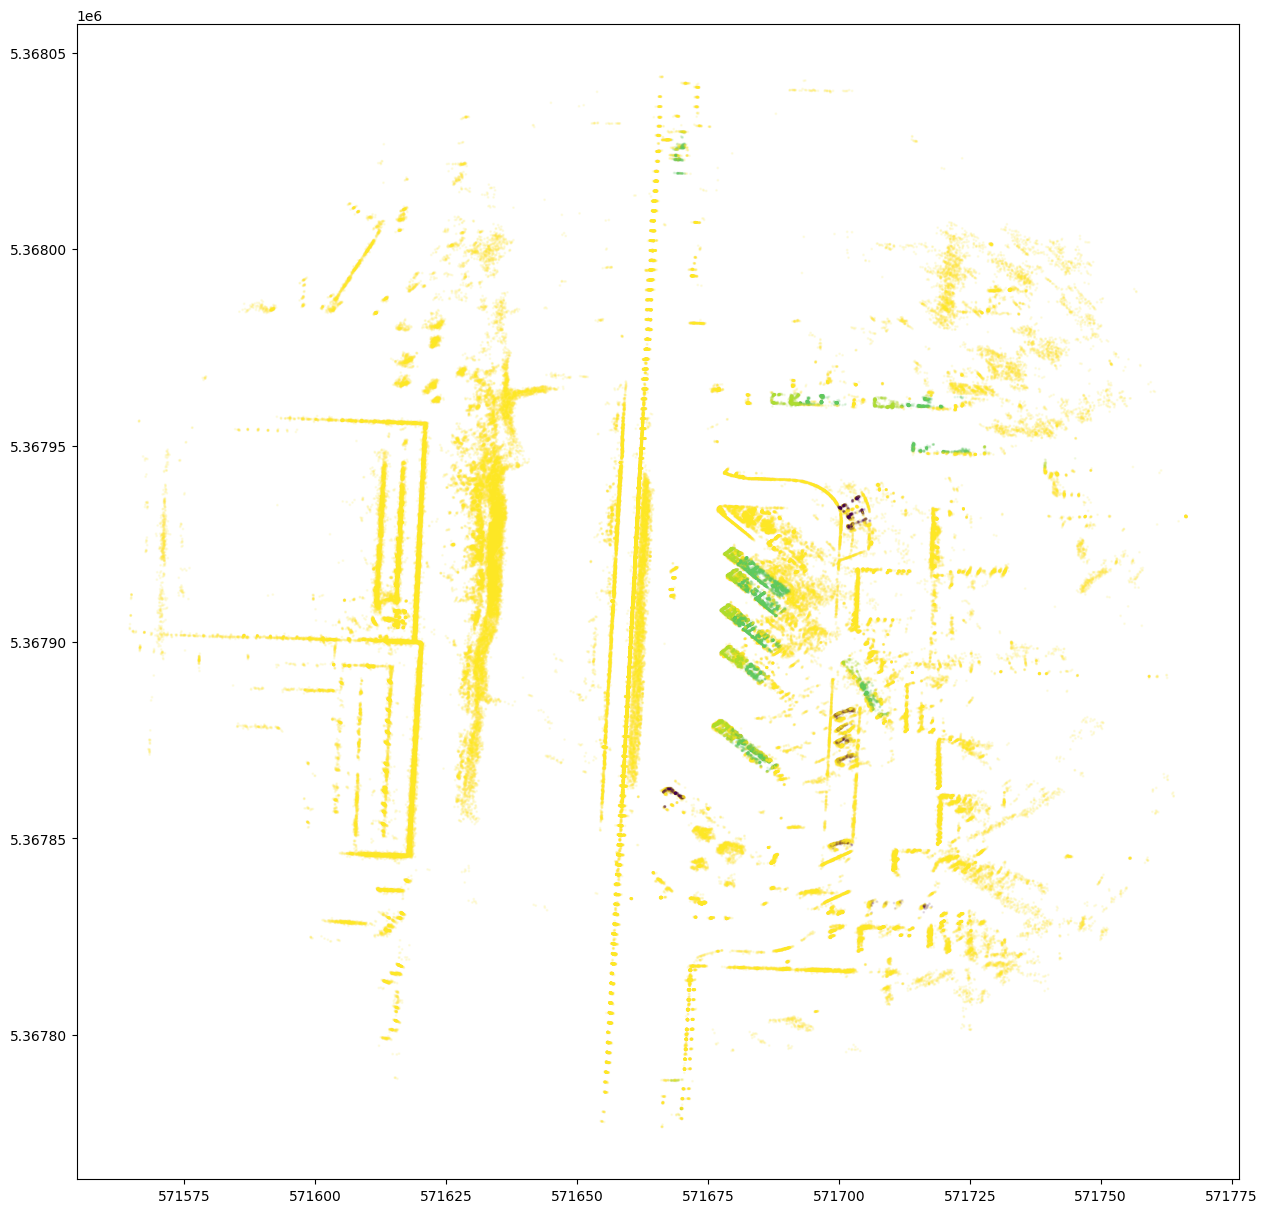

Extracting features:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_130187/1805542479.py:38: RuntimeWarning: Mean of empty slice.
  if Z.mean() > filter_distance:
/home/daniel/anaconda3/envs/hovsg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


IoU for class barrier: 0.0
IoU for class car: 0.0
IoU for class trailer: 0.0975609756097561
IoU for class truck: 0.1456953642384106


/tmp/ipykernel_130187/2399328020.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors_gt = np.array([label_to_color[int(label)] for label in labels_gt])
/tmp/ipykernel_130187/2399328020.py:181: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors_pred = np.array([label_to_color[int(label)] for label in label_pred])


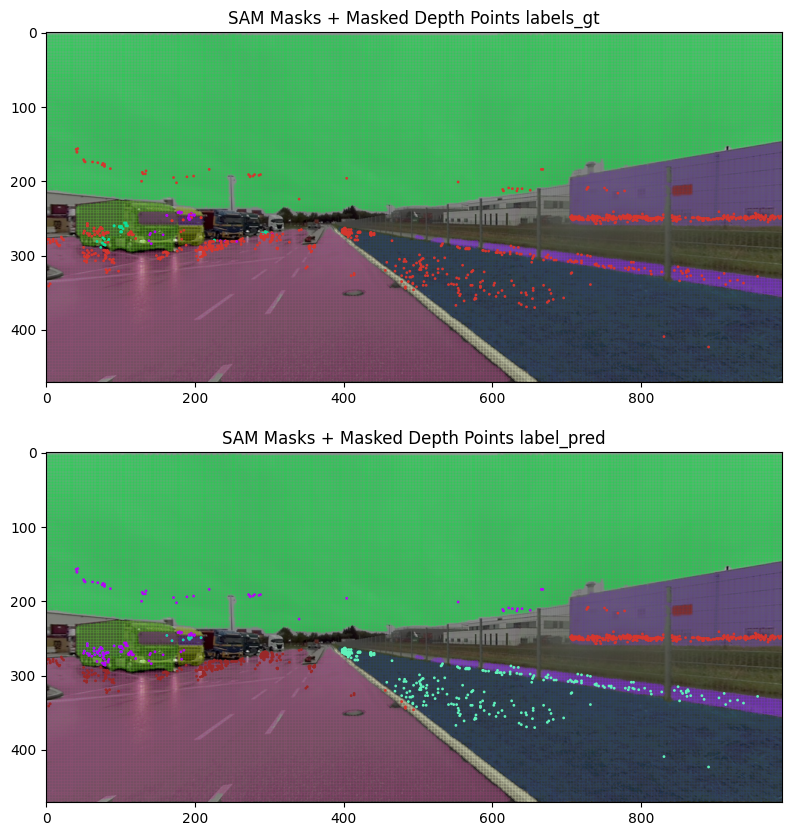

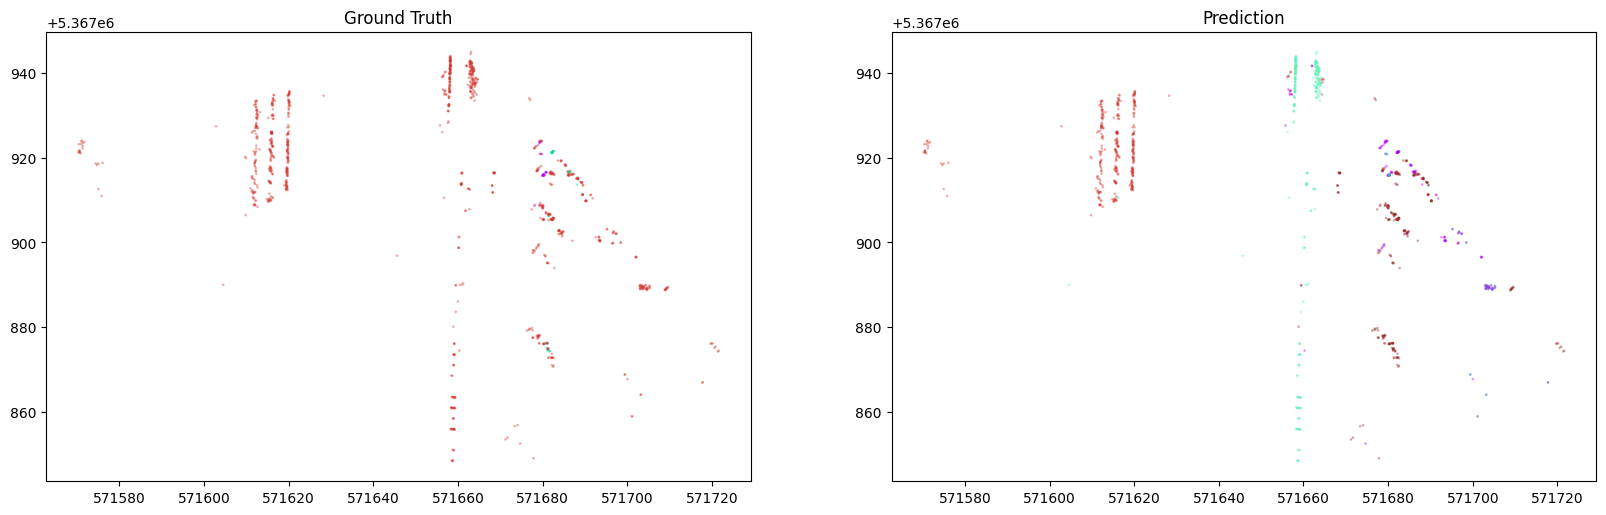

Extracting features:   1%|          | 1/160 [00:04<12:18,  4.65s/it]

IoU for class car: 0.0
IoU for class trailer: 0.0
IoU for class truck: 0.0


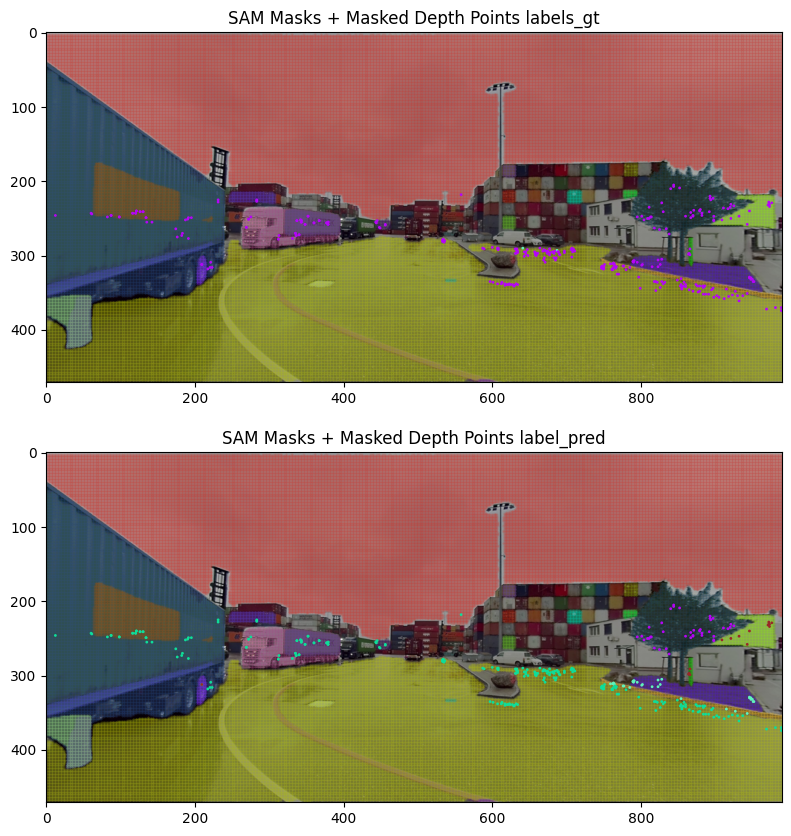

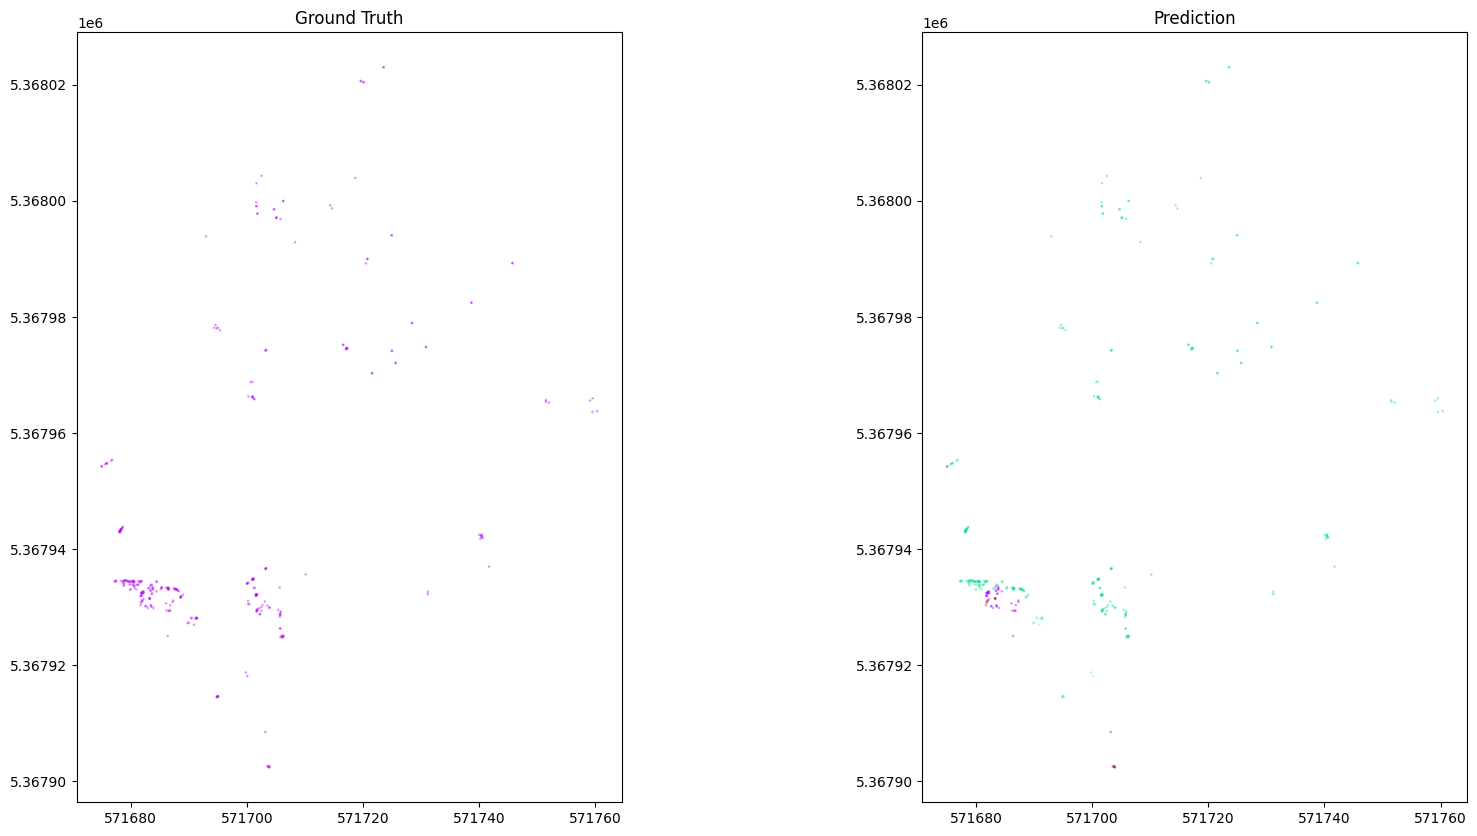

Extracting features:   1%|▏         | 2/160 [00:09<12:31,  4.75s/it]

IoU for class barrier: 0.0
IoU for class car: 0.0
IoU for class trailer: 0.07142857142857142


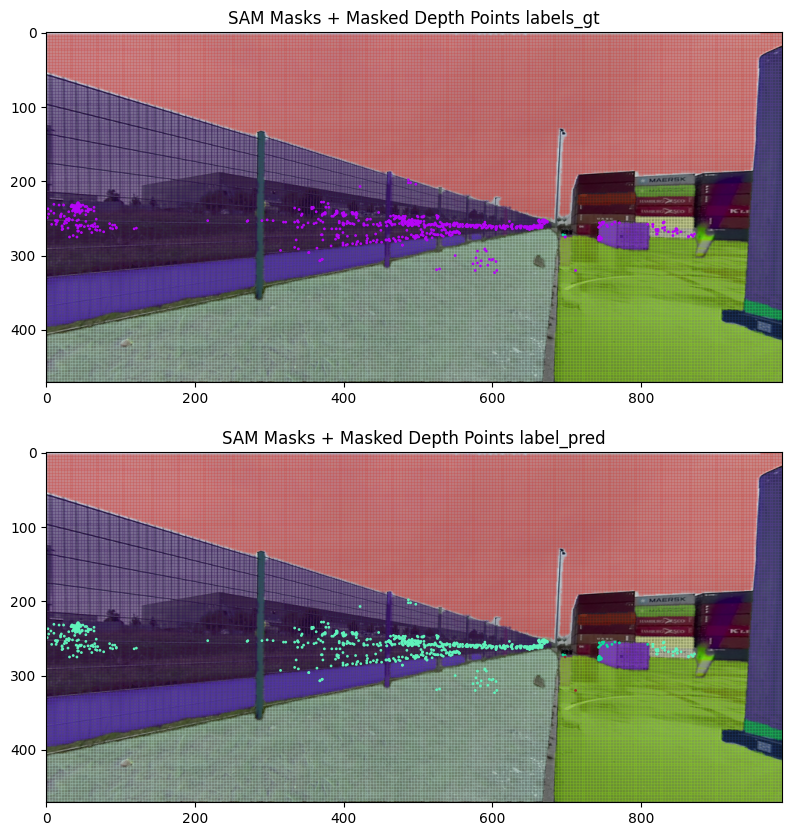

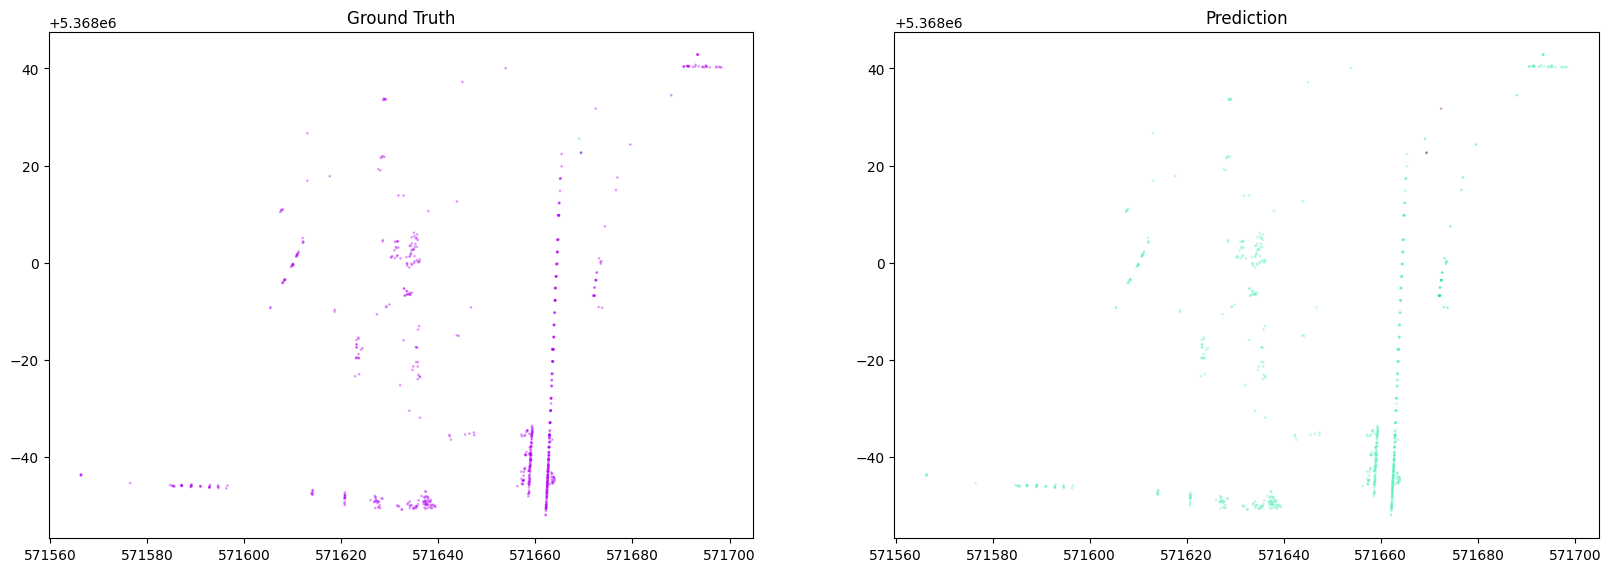

Extracting features:   2%|▏         | 3/160 [00:13<11:05,  4.24s/it]

IoU for class barrier: 0.0
IoU for class car: 0.0
IoU for class person: 0.0
IoU for class trailer: 0.0
IoU for class truck: 0.05357142857142857


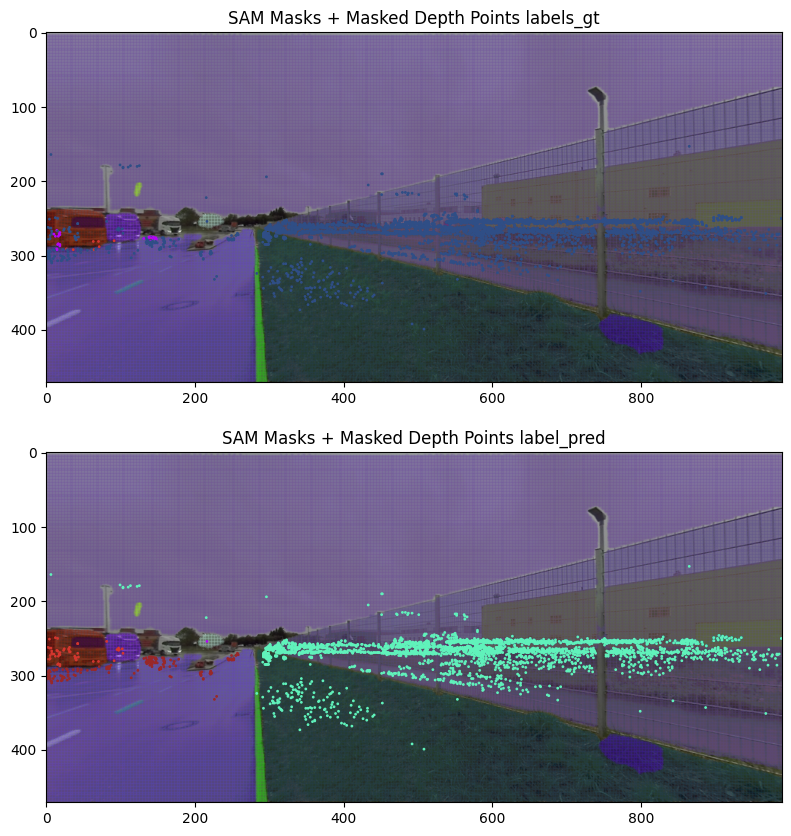

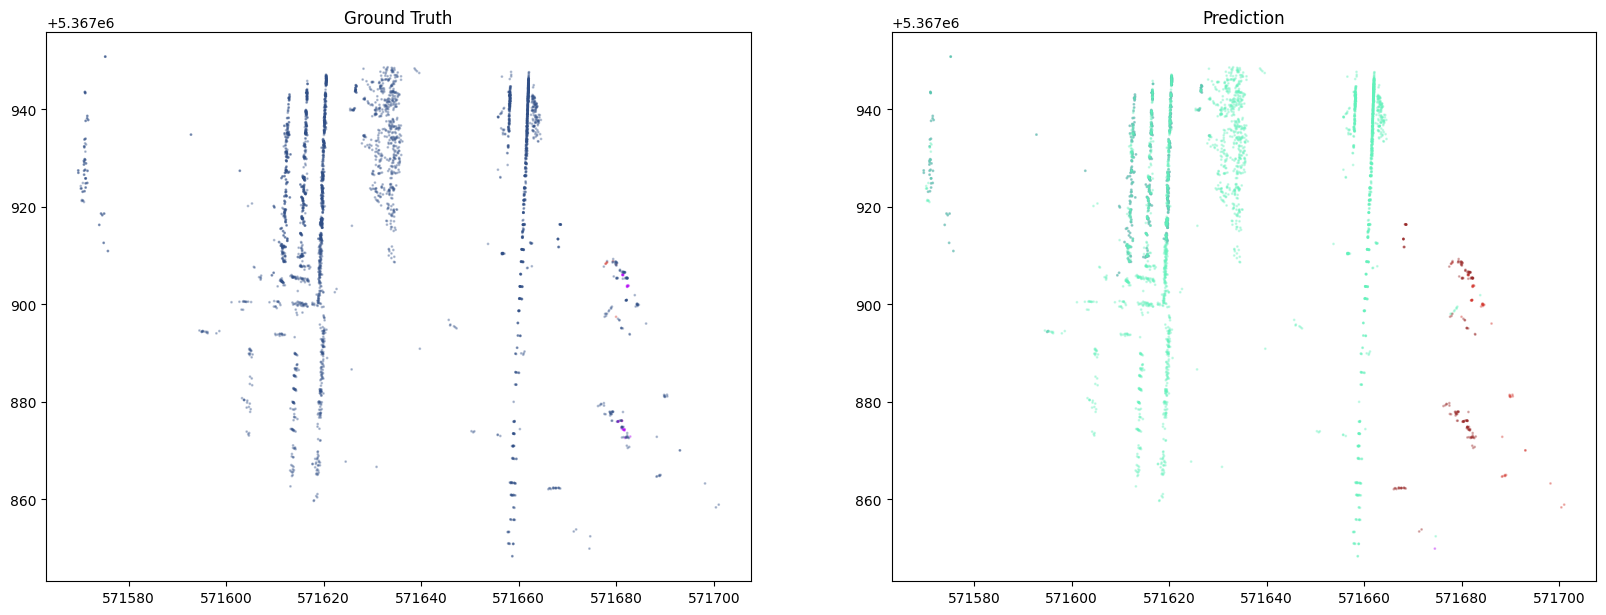

Extracting features:   2%|▎         | 4/160 [00:16<10:34,  4.07s/it]

IoU for class barrier: 0.0
IoU for class car: 0.0
IoU for class trailer: 0.009523809523809525
IoU for class truck: 0.05144694533762058


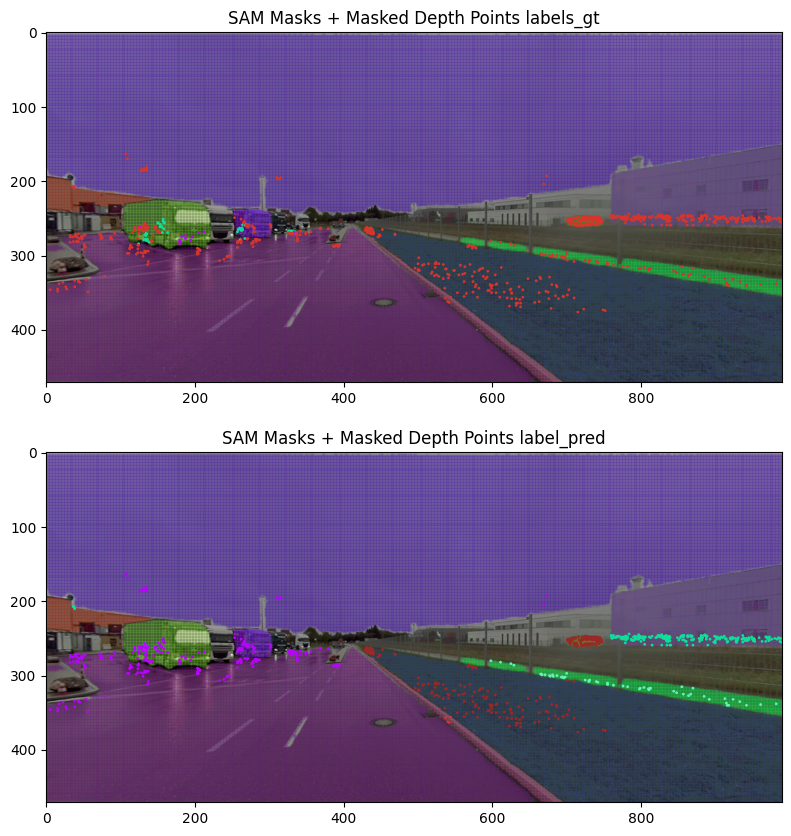

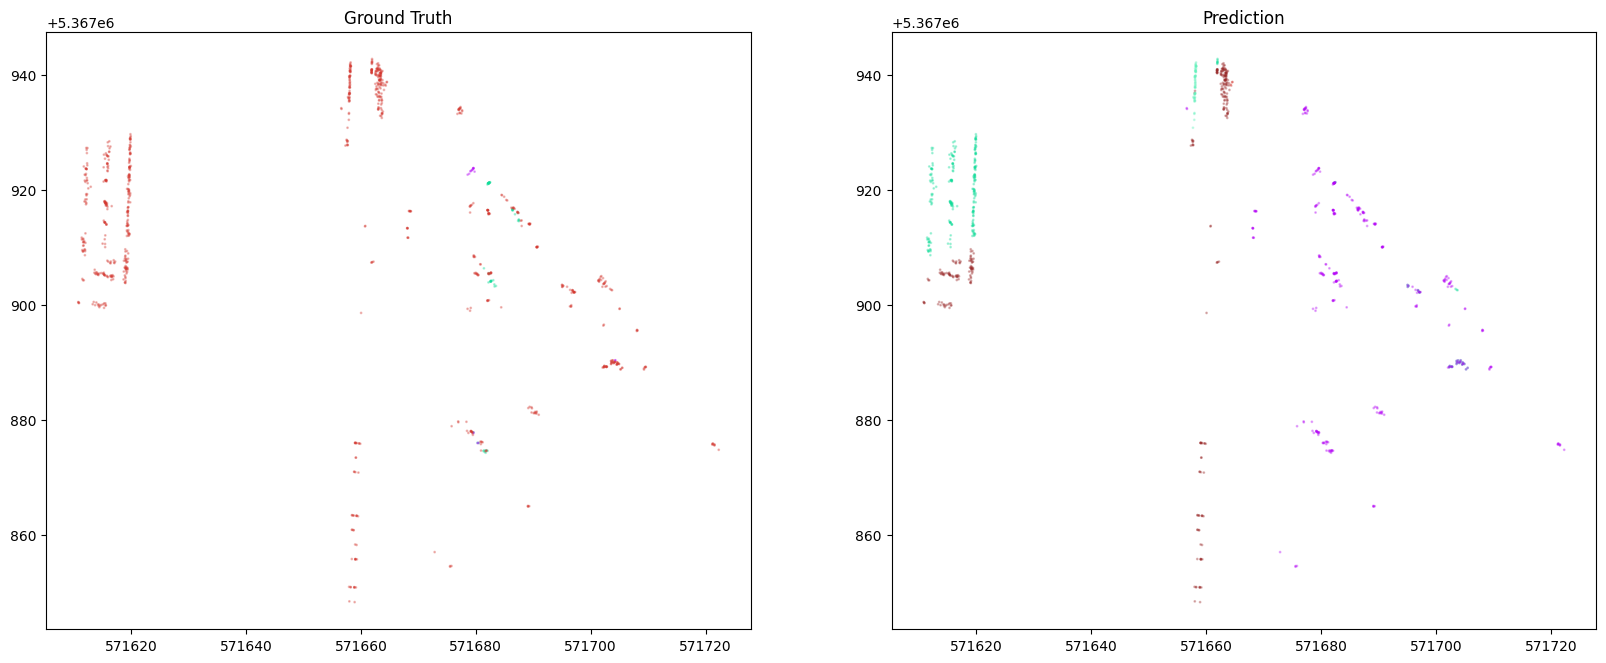

Extracting features:   3%|▎         | 5/160 [00:20<10:30,  4.07s/it]

IoU for class car: 0.012048192771084338
IoU for class trailer: 0.0
IoU for class truck: 0.0


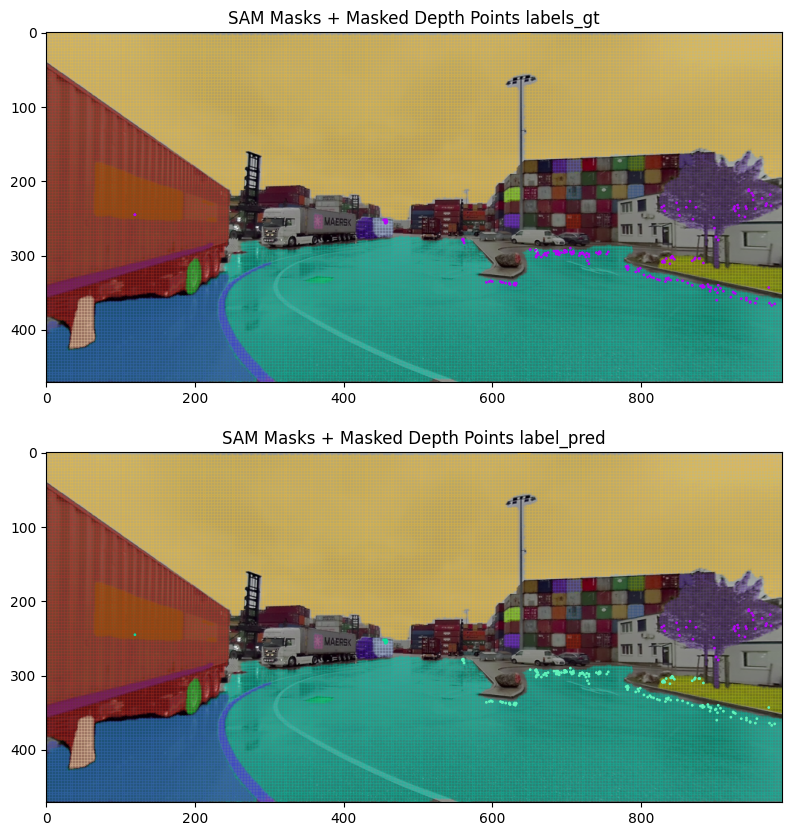

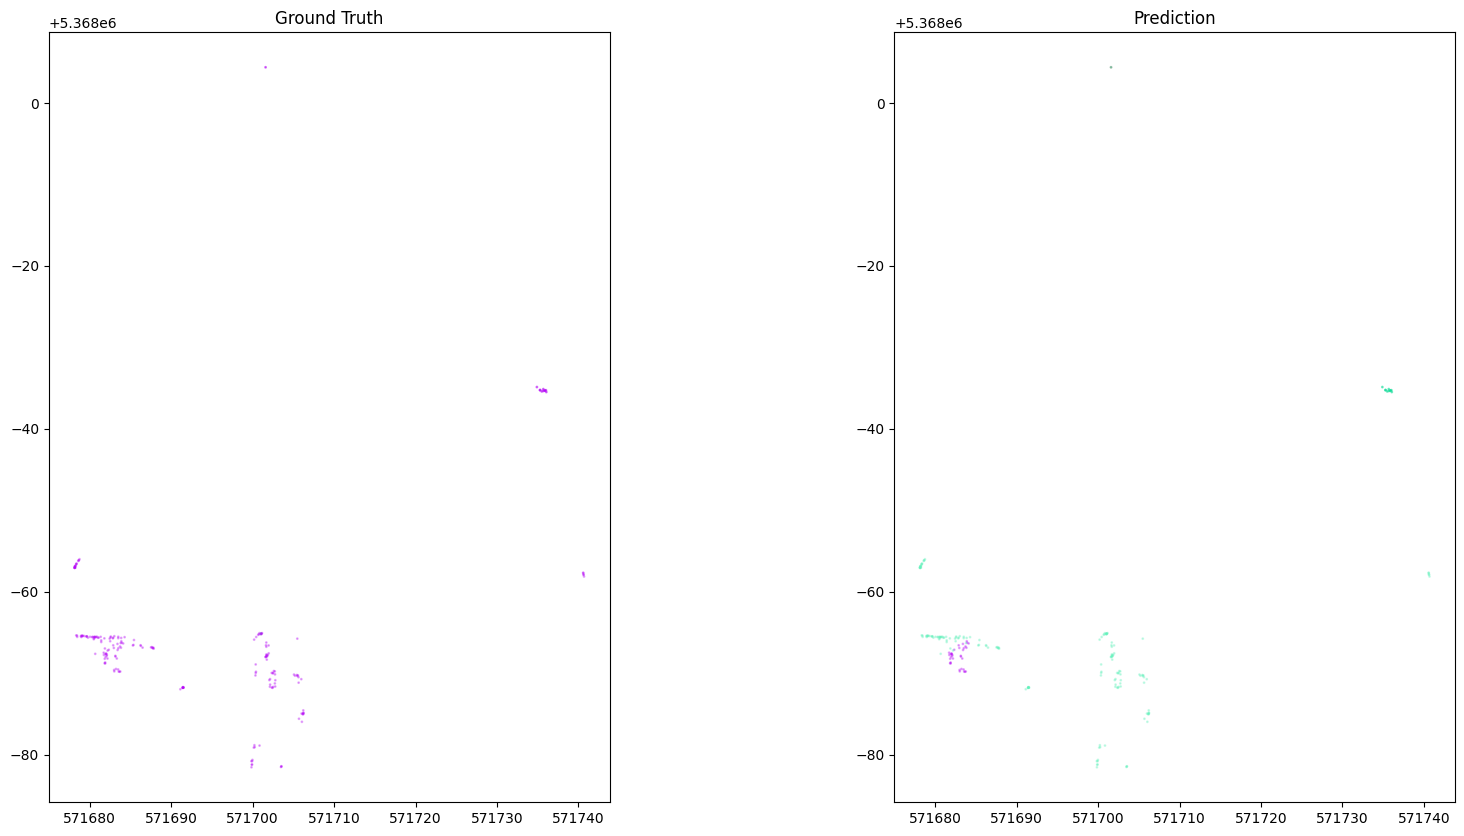

Extracting features:   4%|▍         | 6/160 [00:26<11:55,  4.64s/it]

IoU for class barrier: 0.0
IoU for class trailer: 0.0


/home/daniel/spatial_understanding/benchmarks/HOV-SG/hovsg/utils/metric.py:156: RuntimeWarning: invalid value encountered in scalar divide
  mean_iou_ = np.sum(iou) / (n_cl_gt - n_overlap)
/home/daniel/spatial_understanding/benchmarks/HOV-SG/hovsg/utils/metric.py:195: RuntimeWarning: invalid value encountered in scalar divide
  frequency_weighted_iou_ = np.sum(frequency_weighted_iou_) / sum_k_t_k
/home/daniel/spatial_understanding/benchmarks/HOV-SG/hovsg/utils/metric.py:72: RuntimeWarning: invalid value encountered in divide
  mean_accuracy_ = np.sum(accuracy) / float(n_cl - n_overlap)


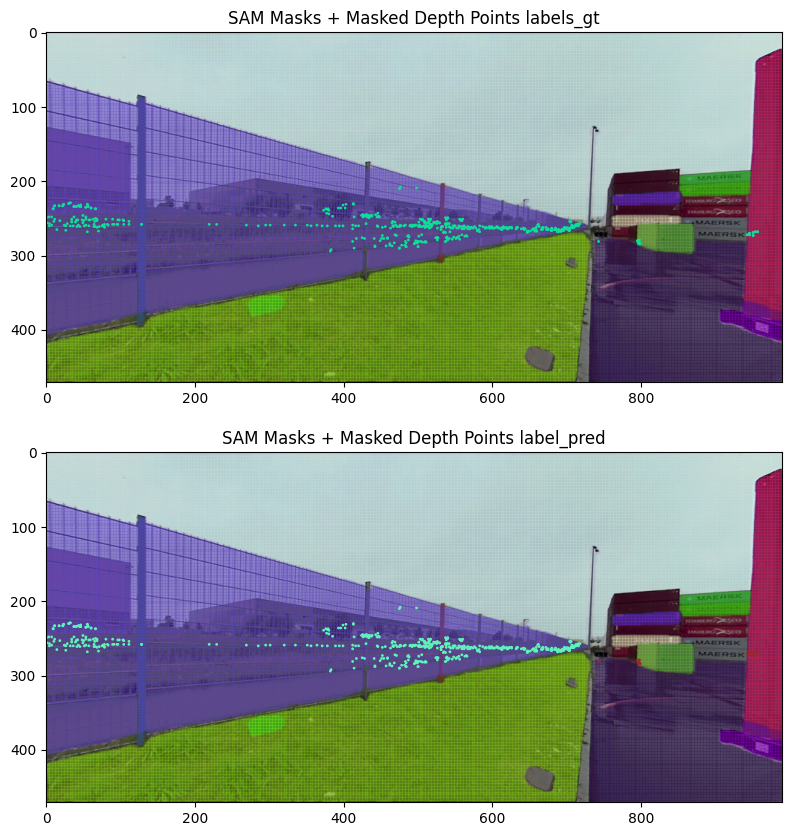

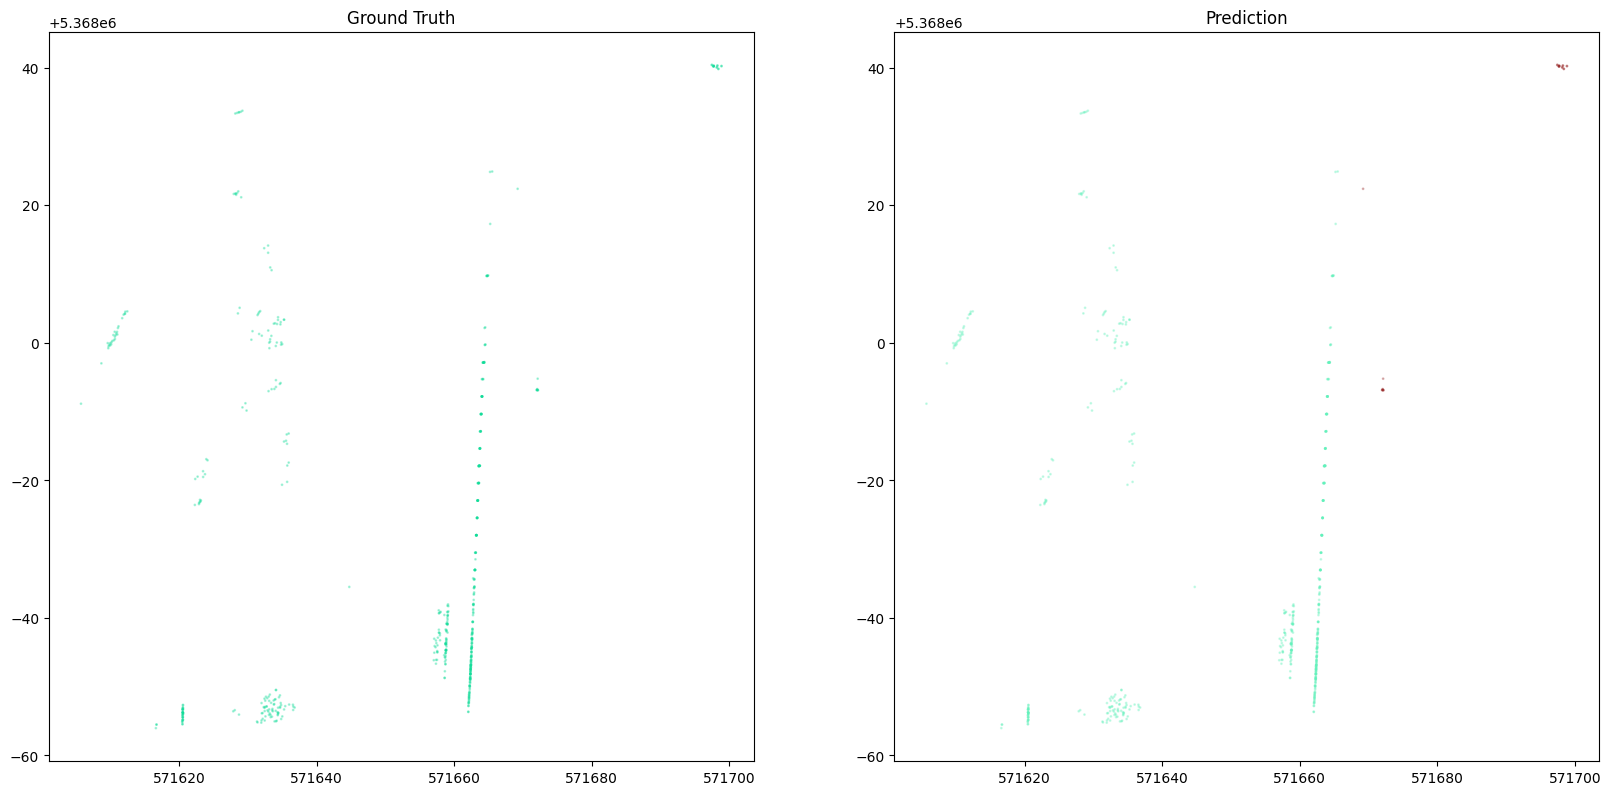

Extracting features:   4%|▍         | 7/160 [00:31<11:33,  4.53s/it]

IoU for class barrier: 0.0
IoU for class car: 0.007556675062972292
IoU for class trailer: 0.0
IoU for class truck: 0.6756756756756757


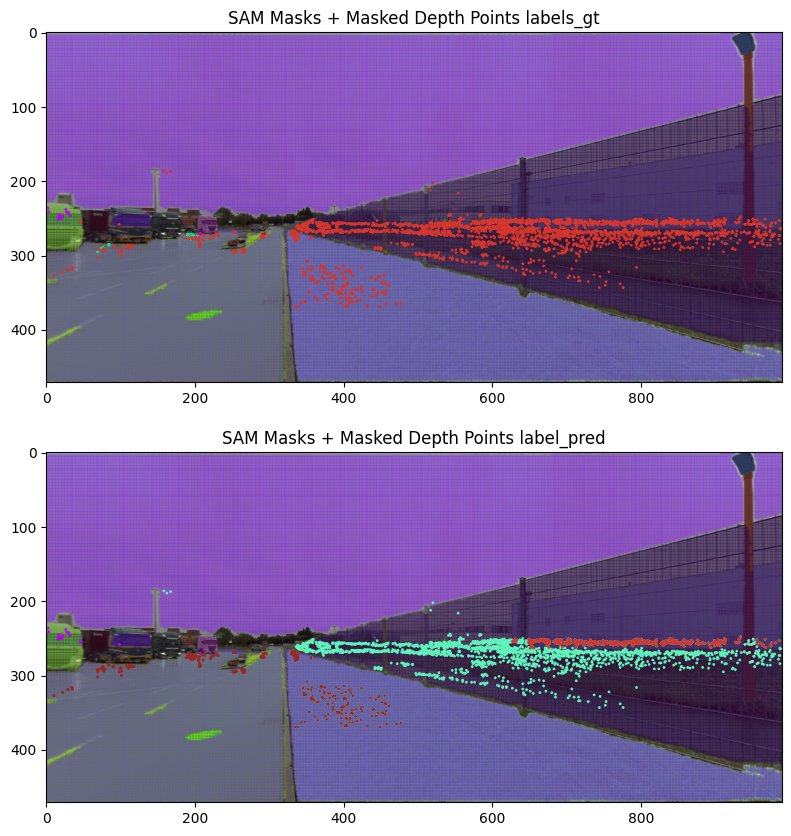

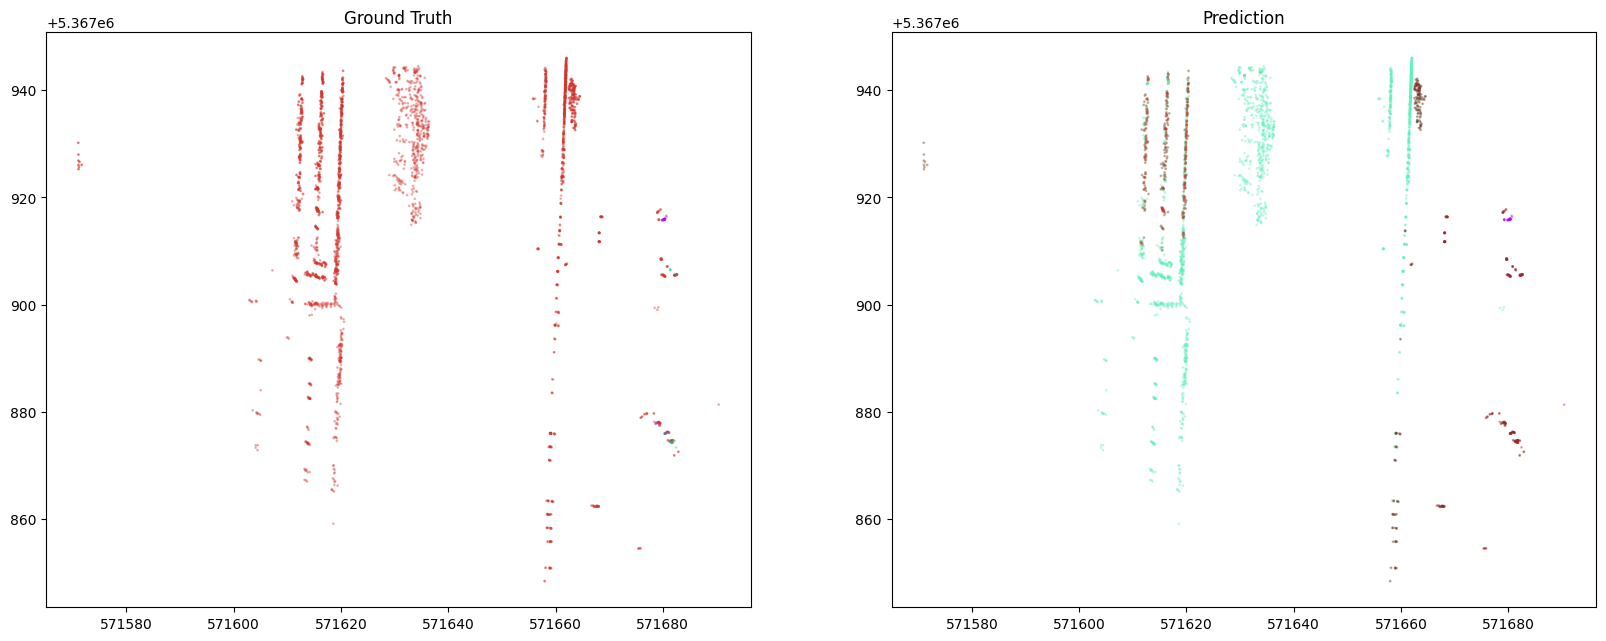

Extracting features:   5%|▌         | 8/160 [00:36<11:27,  4.52s/it]


KeyboardInterrupt: 

In [ ]:
from hovsg.utils.eval_utils import (
    sim_2_label,
    text_prompt,
)


# load ground truth pcd
scene_map_path = f"/shared/data/truckScenes/truckscenes_converted/trainval/{scene_name}/labelled_map.pth"
xyz, feats, label, inst_label = torch.load(scene_map_path, weights_only=False)
label = np.array([TRUCKSCENES_LABELS_TO_IDX.get(l, IGNORE_CLASS_INDEX) for l in label], dtype=np.int64)

# Get corresponding labels for the masks using kdtree
map_pcd = xyz
map_pcd_kdtree = cKDTree(map_pcd[:, :3])


plt.figure(figsize=(15, 15))
plt.scatter(xyz[:, 0], xyz[:, 1], c=label, s=1, alpha=0.1)
plt.show()


# Initialize metrics 
scene_miou = []
scene_fmiou = []
scene_macc = []
scene_pacc = []
class_ious_sums = []

# extract features for each frame
frames_pcd = []
frames_feats = []
for i in tqdm(range(0, len(dataset), cfg.pipeline.skip_frames), desc="Extracting features"):
    ##################################################### INFERENCE
    rgb_image, depth_image, pose, _, _ = dataset[i]
    if rgb_image.size != depth_image.size:
        rgb_image = rgb_image.resize(depth_image.size)
    F_2D, F_masks, masks, F_g = extract_feats_per_pixel(
        np.array(rgb_image),
        mask_generator,
        clip_model,
        preprocess,
        clip_feat_dim=clip_feat_dim,
        bbox_margin=cfg.pipeline.clip_bbox_margin,
        maskedd_weight=cfg.pipeline.clip_masked_weight,
    )
    F_2D = F_2D.cpu()
    
    masks_3d, masks_3d_feats, masks_3d_depth = create_3d_masks(
        dataset,
        masks,
        F_masks,
        depth_image,
        full_pcd,
        tree_pcd,
        pose,
        down_size=cfg.pipeline.voxel_size,
        filter_distance=np.inf #cfg.pipeline.max_mask_distance,
    )
    
    # Get 2D pixel coordinates from the masked depth
    pcd, (x_depth, y_depth, depth_vals) = create_pcd(dataset, rgb_image, depth_image, pose)

    frames_pcd.append(masks_3d)
    frames_feats.append(masks_3d_feats)
    
    # fuse features for each point in the full pcd
    mask = np.array(depth_image) > 0
    mask = torch.from_numpy(mask)
    F_2D = F_2D[mask]
    
    # using cKdtree to find the closest point in the full pcd for each point in frame pcd
    dis, idx = tree_pcd.query(np.asarray(pcd.points), k=1, workers=-1)
    sum_features[idx] += F_2D
    counter[idx] += 1
    # break
    
    ################################################### EVALUATION
    labelled_frame_path = os.path.join(scene_path, labelled_frame_names[i])

    # Load Feature Map
    masked_pcd, mask_feats = masks_3d, masks_3d_feats
    
    if len(masked_pcd) == 0:
        continue

    sim = text_prompt(clip_model, clip_feat_dim, np.array(mask_feats), TRUCKSCENES_LABELS_list, templates=True)
    labels = sim_2_label(sim, labels_id)
    labels = np.array(labels)

    # create a new pcd from the labeld pcd masks
    colors = np.array([TRUCKSCENES_COLORMAP[i] for i in labels]) / 255.0
    colors_map = TRUCKSCENES_COLORMAP
    colors_map = {int(k): np.array(v) / 255.0 for k, v in colors_map.items()}

    
    # Create a mask for the labels that are not within the masked pcd
    # mask = np.zeros(len(
        # map_pcd), dtype=bool)
    
    masked_pcd_modified = []
    gt_labels = []
    gt_points = []
    
    for pcd_mask in masked_pcd:
        # Query neighbors for all masked_pcd points at once
        dists, idxs = map_pcd_kdtree.query(np.array(pcd_mask.points), k=1)
        
        # Create a new point cloud with the masked points
        pcd_mask_o3d = o3d.geometry.PointCloud()
        pcd_mask_o3d.points = o3d.utility.Vector3dVector(xyz[idxs, :3])
        masked_pcd_modified.append(pcd_mask_o3d)
        
        gt_labels.append(label[idxs])
        gt_points.append(xyz[idxs, :3])
        
    gt_labels = np.concatenate(gt_labels, axis=0)
    gt_points = np.concatenate(gt_points, axis=0)


    gt_pcd = o3d.geometry.PointCloud()
    gt_pcd.points = o3d.utility.Vector3dVector(gt_points)
    
    # assing colors to gt pcd based on labels
    colors = np.zeros((len(gt_labels), 3))
    for i, gt_label in enumerate(gt_labels):
        colors[i] = colors_map[gt_label]
    gt_pcd.colors = o3d.utility.Vector3dVector(colors)
    
    
    ## FOR MASK BASED SEGMENTATION ##
    pcd = o3d.geometry.PointCloud()
    for i in range(len(masked_pcd)):
        pcd += masked_pcd_modified[i].paint_uniform_color(colors[i])

    pred_labels = []
    for i in range(len(masked_pcd_modified)):
        pred_labels.append(np.repeat(labels[i], len(masked_pcd_modified[i].points)))
    
    pred_labels = np.hstack(pred_labels)
    pred_labels = pred_labels.reshape(-1, 1)

    gt_labels = gt_labels.reshape(-1, 1)


    labels_gt, label_pred = gt_labels, pred_labels


    # print("labels_gt", labels_gt, "pred_labels", pred_labels)
    ignore = [IGNORE_CLASS_INDEX]

    # print(label_pred, labels_gt, ignore)
    # print("################ {} ################".format(scene_name))
    ious = per_class_iou(label_pred, labels_gt, ignore=ignore, classes=TRUCKSCENES_LABELS)
    # print("per class iou: ", ious)
    miou = mean_iou(label_pred, labels_gt, ignore=ignore)
    # print("miou: ", miou)
    fmiou = frequency_weighted_iou(label_pred, labels_gt, ignore=ignore)
    # print("fmiou: ", fmiou)
    macc = mean_accuracy(label_pred, labels_gt, ignore=ignore)
    # print("macc: ", macc)
    pacc = pixel_accuracy(label_pred, labels_gt, ignore=ignore)
    # print("pacc: ", pacc)

    class_ious_sums.append(ious)
    scene_miou.append(miou)
    scene_fmiou.append(fmiou)
    scene_macc.append(macc)
    scene_pacc.append(pacc)
    
    
    ################################################### VISUALIZATION
    # Get unique labels
    unique_labels = np.unique(np.concatenate([labels_gt, label_pred]))

    # Assign a random RGB color to each label
    np.random.seed(42)  # Optional: for reproducibility
    label_to_color = {label: np.random.rand(3,) for label in unique_labels}

    # Map labels to RGB colors
    colors_gt = np.array([label_to_color[int(label)] for label in labels_gt])
    colors_pred = np.array([label_to_color[int(label)] for label in label_pred])
    
    # Create legend handles
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                markerfacecolor=color, markersize=8)
        for label, color in label_to_color.items()
    ]

    masks_x, masks_y, masks_depth = [], [], []
    for depth_mask in masks_3d_depth:
        x, y, depth = depth_mask
        masks_x.append(x)
        masks_y.append(y)
        masks_depth.append(depth)
        
    masks_x = np.concatenate(masks_x)
    masks_y = np.concatenate(masks_y)
    masks_depth = np.concatenate(masks_depth)
    
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    # Plot the SAM segmentation masks
    ax[0].imshow(rgb_image)
    ax[1].imshow(rgb_image)
    for mask in masks:
        seg = mask["segmentation"]
        ys, xs = np.where(seg)
        color = np.random.rand(3,)
        ax[0].scatter(xs, ys, s=0.1, color=color, alpha=0.2, label="Segmentation")
        ax[1].scatter(xs, ys, s=0.1, color=color, alpha=0.2, label="Segmentation")
    
    # Plot the masked depth points
    # sc = ax[0].scatter(x_depth, y_depth, c=depth_vals, cmap='viridis', s=1, alpha=1)
    sc = ax[0].scatter(masks_x, masks_y, c=colors_gt, s=1, alpha=1)
    ax[0].set_title("SAM Masks + Masked Depth Points labels_gt")
    ax[0].legend(handles=legend_elements, title="Class Labels", loc='upper right', bbox_to_anchor=(1.2, 1))

    
    sc = ax[1].scatter(masks_x, masks_y, c=colors_pred, s=1, alpha=1)
    ax[1].set_title("SAM Masks + Masked Depth Points label_pred")
    ax[1].legend(handles=legend_elements, title="Class Labels", loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.show()
    
    masks_x_3d, masks_y_3d, masks_depth_3d = [], [], []
    for mask_3d in masks_3d:
        mask_3d = np.array(mask_3d.points)
        x, y, depth = mask_3d[:, 0], mask_3d[:, 1], mask_3d[:, 2]
        masks_x_3d.append(x)
        masks_y_3d.append(y)
        masks_depth_3d.append(depth)
        
    masks_x_3d = np.concatenate(masks_x_3d)
    masks_y_3d = np.concatenate(masks_y_3d)
    masks_depth_3d = np.concatenate(masks_depth_3d)
    
    
    # plt.figure(figsize=(20, 10))
    # plt.subplot(1,2,1)
    # plt.scatter(masks_x_3d, masks_y_3d, c=labels_gt, s=1, alpha=0.3)
    # plt.gca().set_aspect('equal')
    
    # plt.subplot(1,2,2)
    # plt.scatter(masks_x_3d, masks_y_3d, c=label_pred, s=1, alpha=0.3)
    # plt.gca().set_aspect('equal')
    # plt.show()
    
        

    # Plot
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.scatter(masks_x_3d, masks_y_3d, c=colors_gt, s=1, alpha=0.3)
    plt.title('Ground Truth')
    plt.gca().set_aspect('equal')

    plt.subplot(1, 2, 2)
    plt.scatter(masks_x_3d, masks_y_3d, c=colors_pred, s=1, alpha=0.3)
    plt.title('Prediction')
    plt.gca().set_aspect('equal')

    plt.show()

In [ ]:
save_dir = os.path.join(params.main.save_path, params.main.dataset, variation, scene_name, "labelled_frames")


In [ ]:
import os
import numpy as np
import torch

# Directory to hold per-frame files
out_dir = "frames_with_feats"
os.makedirs(out_dir, exist_ok=True)

all_pts = 0
for idx, (frame_pcds, frame_feats) in enumerate(zip(frames_pcd, frames_feats)):
    for j, frame in enumerate(frame_pcds):
        # Print size of each frame's point cloud
        print(f"Frame {idx}_{j}, Point Cloud Size: {len(frame.points)}")
    print(len(frame_pcds), len(frame_feats))

In [ ]:
from hovsg.utils.graph_utils import (
    compute_3d_bbox_iou,
    find_overlapping_ratio_faiss,
    connected_components,
    merge_point_clouds_list
)
from matplotlib.patches import Rectangle


def plot_top_view_bboxes(ax, bbox_list):
    for i, bbox in enumerate(bbox_list):
        min_bound = bbox.get_min_bound().tolist()  # Ensures it's a list
        max_bound = bbox.get_max_bound().tolist()
        width = max_bound[0] - min_bound[0]  # X-dim
        height = max_bound[1] - min_bound[1]  # Y-dim
        # print(f"Bounding Box {i}: min_bound={min_bound}, max_bound={max_bound}, width={width}, height={height}")
        rect = Rectangle((min_bound[0], min_bound[1]), width, height, linewidth=1.5, color=np.random.rand(3,))
        ax.add_patch(rect)
        # ax.text(min_bound[0], min_bound[1], str(i), fontsize=8, color=f'C{i % 10}')

    # plt.tight_layout()

def merge_3d_masks(mask_list, overlap_threshold=0.5, radius=0.02, iou_thresh=0.05):
    """
    merge the overlapped 3D masks in the list of masks using matrix
    :param pcd_list (list): list of point clouds
    :param overlap_threshold (float): threshold for overlapping ratio
    :param radius (float): radius for faiss search
    :param iou_thresh (float): threshold for iou
    :return: merged point clouds and features
    """
    
    aa_bb = [pcd.get_axis_aligned_bounding_box() for pcd in mask_list]
    overlap_matrix = np.zeros((len(mask_list), len(mask_list)))
    
    # fig, ax = plt.subplots()

    # create matrix of overlapping ratios
    for i in range(len(mask_list)):
        for j in range(i + 1, len(mask_list)):

            if compute_3d_bbox_iou(aa_bb[i], aa_bb[j]) > iou_thresh:
                overlap_matrix[i, j] = find_overlapping_ratio_faiss(mask_list[i], mask_list[j], radius=1.5 * radius)


                # plot_top_view_bboxes(ax, [aa_bb[i], aa_bb[j]])
                # print(np.array(mask_list[i].points).shape, np.array(mask_list[j].points).shape)
                # plt.scatter(np.array(mask_list[i].points)[:, 0], np.array(mask_list[i].points)[:, 1], s=1, c='blue', label='Mask ' + str(i))
                # plt.scatter(np.array(mask_list[j].points)[:, 0], np.array(mask_list[j].points)[:, 1], s=1, c='red', label='Mask ' + str(j))
                # plot_top_view_bboxes(ax, [aa_bb[j]], title="Top View Before Merging")
        #         break
        # break
    
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_aspect('equal', adjustable='box')
    # plt.grid(True)
    # plt.show()

    # check if overlap_matrix is zero size
    if overlap_matrix.size == 0:
        return mask_list
    graph = overlap_matrix > overlap_threshold
    n_components, component_labels = connected_components(graph)
    component_indices = [np.where(component_labels == i)[0] for i in range(n_components)]
    # merge the masks in each component
    pcd_list_merged = []
    for indices in component_indices:
        pcd_list_merged.append(merge_point_clouds_list([mask_list[i] for i in indices], voxel_size=0.5 * radius))

    # fig, ax = plt.subplots()
    # for merged_pcd in pcd_list_merged:
        # Plot the merged point cloud
        # ax.scatter(np.array(merged_pcd.points)[:, 0], np.array(merged_pcd.points)[:, 1], s=1, c=np.random.rand(3,), label='Merged Mask')
    # plt.title("Top View After Merging")
    # ax.set_aspect('equal', adjustable='box')
    # plt.show()

    return pcd_list_merged


def merge_adjacent_frames(frames_pcd, th, down_size, proxy_th):
    """
        Merge adjacent frames in the list of frames
        :param frames_pcd (list): list of point clouds
        :param th (float): threshold for overlapping ratio
        :param down_size (float): radius for downsampling
        :param proxy_th (float): threshold for iou
        :return: merged point clouds and features
    """
    new_frames_pcd = []
    for i in tqdm(range(0, len(frames_pcd), 2)):
        # if the number of frames is odd, the last frame is appended without merging.
        if i == len(frames_pcd) - 1:
            new_frames_pcd.append(frames_pcd[i])
            break
        pcd_list = frames_pcd[i] + frames_pcd[i + 1]

        pcd_list = merge_3d_masks(
            pcd_list,
            overlap_threshold=th,
            radius=down_size,
            iou_thresh=proxy_th,
        )
        new_frames_pcd.append(pcd_list)

    return new_frames_pcd

def hierarchical_merge(frames_pcd, th, th_factor, down_size, proxy_th):
    """
        Hierarchical merge the frames in the list of frames
        :param frames_pcd (list): list of point clouds
        :param th (float): threshold for overlapping ratio
        :param th_factor (float): factor for decreasing the threshold
        :param down_size (float): radius for downsampling
        :param proxy_th (float): threshold for iou
        :return: merged point clouds and features
    """
    while len(frames_pcd) > 1:
        frames_pcd = merge_adjacent_frames(frames_pcd, th, down_size, proxy_th)
        if len(frames_pcd) > 1:
            th -= th_factor * (len(frames_pcd) - 2) / max(1, len(frames_pcd) - 1)
            print("th: ", th)
        break
    # apply one more merge
    frames_pcd = frames_pcd[0]
    frames_pcd = merge_3d_masks(
        frames_pcd, overlap_threshold=0.75, radius=down_size, iou_thresh=proxy_th
    )
    return frames_pcd

In [ ]:
# Plot all the masks for all the frames in frames_pcd
plt.figure(figsize=(10, 10))
for frame in frames_pcd:
    for i, mask_3d in enumerate(frame):
        points = np.asarray(mask_3d.points)
        plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label=f"Mask {i}")
plt.title("All Masks from All Frames")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [ ]:
full_feats_array.shape

In [ ]:
# compute the average features
counter[counter == 0] = 1e-5
sum_features = sum_features / counter
full_feats_array = sum_features.cpu().numpy()
full_feats_array: np.ndarray

# del sum_features, counter
# torch.cuda.empty_cache() 

# merging the masks
# if cfg.pipeline.merge_type == "hierarchical":
#     tqdm.write("Merging 3d masks hierarchically")
#     mask_pcds = hierarchical_merge(
#         frames_pcd, 
#          0.75, # 0.75, #cfg.pipeline.init_overlap_thresh, 
#          0.025, # 0.025, #cfg.pipeline.overlap_thresh_factor, 
#          0.021, # 0.021, #cfg.pipeline.voxel_size, 
#          0.5, # 0.05, #cfg.pipeline.iou_thresh,
#     )
# elif cfg.pipeline.merge_type == "sequential":
tqdm.write("Merging 3d masks sequentially") 
mask_pcds = seq_merge(
    frames_pcd, 
    0.01, # 0.75, #cfg.pipeline.init_overlap_thresh, 
    0.1, # 0.021, #cfg.pipeline.voxel_size, 
    0.5, # 0.05, #cfg.pipeline.iou_thresh,
)


In [ ]:
# remove any small pcds
for i, pcd in enumerate(mask_pcds):
    if pcd.is_empty() or len(pcd.points) < cfg.pipeline.min_pcd_points:
        mask_pcds.pop(i)
        
# fuse point features in every 3d mask
masks_feats = []
for i, mask_3d in tqdm(enumerate(mask_pcds), desc="Fusing features"):
    # find the points in the mask
    mask_3d = mask_3d.voxel_down_sample(cfg.pipeline.voxel_size * 2)
    points = np.asarray(mask_3d.points)
    dist, idx = tree_pcd.query(points, k=1, workers=-1)
    feats = full_feats_array[idx]
    feats = np.nan_to_num(feats)
    # filter feats with dbscan
    if feats.shape[0] == 0:
        masks_feats.append(
            np.zeros((1, clip_feat_dim), dtype=full_feats_array.dtype)
        )
        continue
    # print("Before", feats.shape)
    # feats = feats_denoise_dbscan(feats, eps=0.01, min_points=100)
    feats = feats_denoise_dbscan(feats, eps=10, min_points=5)
    # print("After", feats.shape)
    
    masks_feats.append(feats)
mask_feats = masks_feats
print("number of masks: ", len(mask_feats))
print("number of pcds in hovsg: ", len(mask_pcds))
assert len(mask_pcds) == len(mask_feats)


In [ ]:
count_points = 0
plt.figure(figsize=(10, 10))
plt.scatter(np.asarray(full_pcd.points)[:, 0], np.asarray(full_pcd.points)[:, 1], s=1, c='gray', alpha=0.5, label="Full PCD")
for i, mask_3d in enumerate(mask_pcds):
    points = np.asarray(mask_3d.points)
    plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label=f"Mask {i}")
    count_points += points.shape[0]
plt.title("3D Masks")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
print("Total number of points", np.array(full_pcd.points).shape[0])
print("Total number of points in masks", count_points)

In [ ]:
exit(-1)


In [ ]:
state = "both"
path = os.path.join(cfg.main.save_path, cfg.main.dataset)
# def save_masked_pcds(self, path, state="both"):
# """
# Save the masked pcds to disk
# :params state: str 'both' or 'objects' or 'full' to save the full masked pcds or only the objects.
# """
# # # remove any small pcds
# tqdm.write("-- removing small and empty masks --")
# for i, pcd in enumerate(mask_pcds):
#     if len(pcd.points) < 50:
#         mask_pcds.pop(i)
#         mask_feats.pop(i)

for i, pcd in enumerate(mask_pcds):
    if pcd.is_empty():
        mask_pcds.pop(i)
        mask_feats.pop(i)

objects_path = os.path.join(path, "objects")

if state == "both":
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.exists(objects_path):
        os.makedirs(objects_path)
    print("number of masked pcds: ", len(mask_pcds))
    print("number of mask_feats: ", len(mask_feats))
    for i, pcd in enumerate(mask_pcds):
        o3d.io.write_point_cloud(
            os.path.join(objects_path, "pcd_{}.ply".format(i)), pcd
        )

    masked_pcd = o3d.geometry.PointCloud()
    for pcd in mask_pcds:
        pcd.paint_uniform_color(np.random.rand(3))
        masked_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(path, "masked_pcd.ply"), masked_pcd)
    print("masked pcds saved to disk in {}".format(path))

elif state == "objects":
    if not os.path.exists(path):
        os.makedirs(path)
    for i, pcd in enumerate(mask_pcds):
        o3d.io.write_point_cloud(
            os.path.join(objects_path, "pcd_{}.ply".format(i)), pcd
        )
    print("masked pcds saved to disk in {}".format(path))

elif state == "full":
    if not os.path.exists(path):
        os.makedirs(path)
    masked_pcd = o3d.geometry.PointCloud()
    for pcd in mask_pcds:
        pcd.paint_uniform_color(np.random.rand(3))
        masked_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(path, "masked_pcd.ply"), masked_pcd)
    print("masked pcds saved to disk in {}".format(path))


In [ ]:

# def save_full_pcd(self, path):
# """
# Save the full pcd to disk
# :param path: str, The path to save the full pcd
# """
if not os.path.exists(path):
    os.makedirs(path)
o3d.io.write_point_cloud(os.path.join(path, "full_pcd.ply"), full_pcd)
print("full pcd saved to disk in {}".format(path))

In [ ]:

# def save_full_pcd_feats(self, path):
# """
# Save the full pcd with feats to disk
# :param path: str, The path to save the full pcd feats
# """
if not os.path.exists(path):
    os.makedirs(path)
# check if the full pcd feats is empty list
if len(mask_feats) != 0:
    mask_feats = np.array(mask_feats)
    torch.save(
        torch.from_numpy(mask_feats), os.path.join(path, "mask_feats.pt")
    )
if len(full_feats_array) != 0:
    torch.save(
        torch.from_numpy(full_feats_array),
        os.path.join(path, "full_feats.pt"),
    )
print("full pcd feats saved to disk in {}".format(path))

In [ ]:
import torch 
import pickle
import os
import numpy as np
scene = "scene-0c2e941c5ba2476b9e20b29ce4c678b9-3"
scene_path = f"/home/daniel/spatial_understanding/benchmarks/HOV-SG/truckscenes/modified_seq_merge_params/{scene}"
labelled_path = os.path.join(scene_path, "labelled_frames")
labelled_frames_paths = sorted(os.listdir(labelled_path), key=lambda x: int(x.split('_')[-1].split('.')[0]))

labelled_map_path = f"/shared/data/truckScenes/truckscenes_converted/trainval/{scene}/labelled_map.pth"
xyz, _, label, _ = torch.load(labelled_map_path, weights_only=False)


In [ ]:
from scipy.spatial import cKDTree
tree = cKDTree(xyz[:, :3])
    
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(xyz[:, 0], xyz[:, 1], s=1, c='gray', alpha=0.5, label="Full Map")

    
for frame_path in labelled_frames_paths:
    frame_path = os.path.join(labelled_path, frame_path)
    with open(frame_path, 'rb') as f:
        frame_data = pickle.load(f)
        
    # print(f"Frame: {frame_path}, Data: {frame_data.keys()}")
    # Do something with the frame data
    # For example, you can access the point cloud and features like this:
    pcds = frame_data['points']
    feats = frame_data['features']
    
    labels = []
    for pcd, feat in zip(pcds, feats):
        print(pcd.shape)
        # Get the labels of the pcd by querying a kdtree with the full labelled map
        dist, idx = tree.query(pcd, k=1, workers=-1)
        print(dist)
        labels.append(label[idx])


    # Plot current pcd and full map
    for points, feat in zip(pcds, feats):
        plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label="PCD")
        
plt.title("3D Masks")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

    # print(len(labels), len(pcds))